Récupération du jeu de données

In [1]:
!tar -xzf test_technique.tar.gz --exclude=".*"

In [2]:
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from collections import Counter
import seaborn as sns
# import tensorflow_datasets as tfds
import albumentations as A
from functools import partial

import splitfolders

import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling, Layer, BatchNormalization, InputLayer

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# AUTOTUNE = tf.data.experimental.AUTOTUNE
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint

In [3]:
batch_size = 32
img_width = 224
img_height = 224

path = os.path.abspath('./Test_Technique_Image/Neuroflux_disorder/')
outpath = './Test_Technique_Image'
classes = os.listdir(path)
classes

['EO', 'IO', 'IPTE', 'LO', 'PTE']

Après avoir récupéré le data set, nous allons le diviser en trois sous dossier. Un pour l'entraînement, un pour la validation et un pour les tests. Le split se fait avec un pourcentage de 70/20/10.

In [ ]:
splitfolders.ratio(path,
                    output='./Test_Technique_Image',
                    seed=42,
                    ratio=(.7, .2, .1),
                    group_prefix=None,
                    move=True
                    )

In [ ]:
train_path = outpath + "\\train" 
val_path = outpath + "\\val" 
test_path = outpath + "\\test" 

In [ ]:
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                               )

test_data_gen = ImageDataGenerator(rescale = 1./255)

Etant donné le peu de données, nous mettons en place un ImageDataGenerator permettant l'application de filtres sur les données d'entraînement. Nous laissons cependant les données de validation et de test inchangées (seulement une normalisation).

In [13]:
from tensorflow.python.framework.op_def_library_pybind import process_inputs
from keras.api._v2.keras import preprocessing



train_ds = image_gen.flow_from_directory(
    train_path,
    seed=42,
    shuffle=True,
    batch_size=batch_size,
    target_size = (img_height, img_width)
    )

val_ds = image_gen.flow_from_directory(
    val_path,
    seed=42,
    shuffle=True,
    batch_size=batch_size,
    target_size = (img_height, img_width)
    )

test_ds = test_data_gen.flow_from_directory(
    test_path,
    seed=123,
    batch_size=batch_size,
    target_size = (img_height, img_width)
    )

NameError: name 'image_gen' is not defined

In [ ]:
cdic = {}
for i in range(len(classes)):
    cdic[i] = classes[i]

In [ ]:
def np_to_int(nparr):
    for i in range(len(nparr)):
        if nparr[i] == 1:
            return i
    return 0

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train_ds:
        image = X_batch[0]        
        plt.axis('off')
        plt.title(cdic[np_to_int(Y_batch[0])])
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [ ]:
# ------------- Liste des classes et leur représentation dans le dataset -------------
classes_and_number = sorted(counts.items(), key = lambda x: x[1], reverse = True)[:13]

Y = []
for c in classes:
    if c in labels:
        dir_path = os.path.join(path, c)
        label = labels.index(c)
        for i in os.listdir(dir_path):
            Y.append(label)


# ------------- Liste des labels -------------

obj = Counter(Y)

fig = plt.figure(figsize = (15, 5))
sns.barplot(x = [labels[i] for i in obj.keys()], y = list(obj.values())).set_title("Nombre d'images dans chaque classe")
plt.margins(x = 0)
plt.show()

In [25]:
train = tf.keras.utils.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    batch_size=32,
    image_size=(32, 32),
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
)

val = tf.keras.utils.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    batch_size=32,
    image_size=(32, 32),
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
)


Found 1296 files belonging to 5 classes.
Using 1037 files for training.
Found 1296 files belonging to 5 classes.
Using 1037 files for training.


Liste des classes et leur représentation dans le dataset :

[('PTE', 580), ('LO', 240), ('EO', 233), ('IPTE', 171), ('IO', 72)]


Liste des labels :

['PTE', 'LO', 'EO', 'IPTE', 'IO']




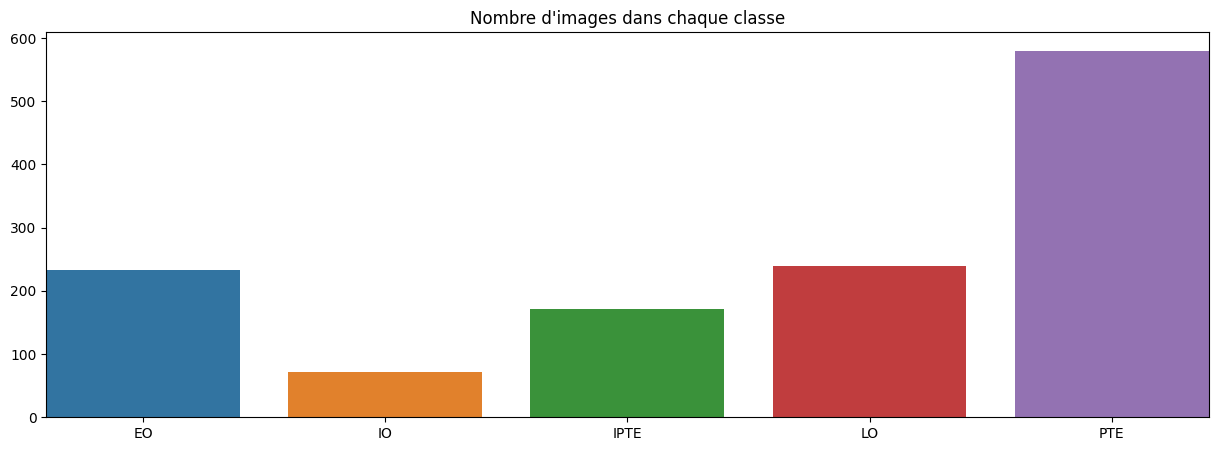

In [37]:
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))


# ------------- Liste des classes et leur représentation dans le dataset -------------
classes_and_number = sorted(counts.items(), key = lambda x: x[1], reverse = True)[:13]
print("Liste des classes et leur représentation dans le dataset :\n")
print(classes_and_number)
print("\n")


# ------------- Liste des labels -------------
labels = [i[0] for i in classes_and_number]
print("Liste des labels :\n")
print(labels)
print("\n")


# ------------- Plotting du nombre d'images dans chaque classe -------------
Y = []
for c in classes:
    if c in labels:
        dir_path = os.path.join(path, c)
        label = labels.index(c)
        for i in os.listdir(dir_path):
            Y.append(label)

obj = Counter(Y)

fig = plt.figure(figsize = (15, 5))
sns.barplot(x = [labels[i] for i in obj.keys()], y = list(obj.values())).set_title("Nombre d'images dans chaque classe")
plt.margins(x = 0)
plt.show()

On peut voir que le jeu de données est déséquilibré et que cela va fausser l'entraînement de notre réseau de convolution. Nous allons donc mettre en place des poids pour que le réseau apprenne correctement.

In [26]:
counts = {}
total_files = 0
for c in classes:
    length = len(os.listdir(os.path.join(path, c)))
    counts[c] = length
    total_files += length
    
for k, v in counts.items():
    counts[k] = 1 / v * 100

coeff = {}
for i in range(len(counts)):
    coeff[i] = counts[classes[i]]
    
coeff

{0: 0.4291845493562232,
 1: 1.3888888888888888,
 2: 0.5847953216374269,
 3: 0.4166666666666667,
 4: 0.1724137931034483}

In [27]:
flip = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomFlip("horizontal"),
    ]
)
rot = Sequential(
    [
        layers.RandomRotation(0.5),
        layers.RandomRotation(factor=0.15),
        layers.RandomZoom(0.2, 0.3),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.1),
    ]
)

rot2 = Sequential(
    [
        layers.RandomRotation(0.5),
        layers.RandomZoom((-0.2, -0.3)),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.8),
    ]
)

augmented_rot = train.map(
  lambda x, y: (rot(x, training=True), y))

augmented_rot2 = train.map(
  lambda x, y: (rot2(x, training=True), y))

augmented_flip = train.map(
  lambda x, y: (flip(x, training=True), y))

train = train.concatenate(augmented_flip).concatenate(augmented_rot).concatenate(rot2)


AttributeError: 'Sequential' object has no attribute 'element_spec'

In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Sequential()
model.add(Rescaling(1./255))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))


model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())


model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))


model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [29]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'Recall'])

In [30]:
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

In [31]:
fit = model.fit(train,epochs=100, validation_data=val)#, class_weight = coeff,callbacks=[mcp_save, reduce_lr_loss])

Epoch 1/100
33/33 [==============================] - 9s 173ms/step - loss: 2.7615 - accuracy: 0.2150 - recall: 0.1456 - val_loss: 1.5542 - val_accuracy: 0.3867 - val_recall: 0.0000e+00
Epoch 2/100
33/33 [==============================] - 6s 169ms/step - loss: 2.7416 - accuracy: 0.2257 - recall: 0.1678 - val_loss: 1.5675 - val_accuracy: 0.1794 - val_recall: 0.0000e+00
Epoch 3/100
33/33 [==============================] - 6s 170ms/step - loss: 2.6165 - accuracy: 0.2411 - recall: 0.1823 - val_loss: 1.5567 - val_accuracy: 0.1794 - val_recall: 0.0000e+00
Epoch 4/100
33/33 [==============================] - 6s 171ms/step - loss: 2.5718 - accuracy: 0.2257 - recall: 0.1572 - val_loss: 1.5895 - val_accuracy: 0.1765 - val_recall: 0.0000e+00
Epoch 5/100
33/33 [==============================] - 6s 179ms/step - loss: 2.6371 - accuracy: 0.2295 - recall: 0.1716 - val_loss: 1.5989 - val_accuracy: 0.1871 - val_recall: 0.0000e+00
Epoch 6/100
33/33 [==============================] - 6s 168ms/step - loss: 

Epoch 46/100
33/33 [==============================] - 6s 190ms/step - loss: 1.6766 - accuracy: 0.3848 - recall: 0.2671 - val_loss: 1.1537 - val_accuracy: 0.5709 - val_recall: 0.2729
Epoch 47/100
33/33 [==============================] - 6s 191ms/step - loss: 1.6098 - accuracy: 0.4050 - recall: 0.2758 - val_loss: 1.1595 - val_accuracy: 0.5699 - val_recall: 0.2392
Epoch 48/100
33/33 [==============================] - 6s 188ms/step - loss: 1.6756 - accuracy: 0.3944 - recall: 0.2690 - val_loss: 1.1533 - val_accuracy: 0.5786 - val_recall: 0.2372
Epoch 49/100
33/33 [==============================] - 6s 183ms/step - loss: 1.6434 - accuracy: 0.4002 - recall: 0.2845 - val_loss: 1.1137 - val_accuracy: 0.5892 - val_recall: 0.2739
Epoch 50/100
33/33 [==============================] - 6s 185ms/step - loss: 1.6385 - accuracy: 0.3963 - recall: 0.2797 - val_loss: 1.0977 - val_accuracy: 0.6017 - val_recall: 0.2989
Epoch 51/100
33/33 [==============================] - 6s 185ms/step - loss: 1.6694 - accur

33/33 [==============================] - 6s 190ms/step - loss: 1.1918 - accuracy: 0.5545 - recall: 0.4446 - val_loss: 0.7020 - val_accuracy: 0.8149 - val_recall: 0.5921
Epoch 92/100
33/33 [==============================] - 6s 190ms/step - loss: 1.1863 - accuracy: 0.5583 - recall: 0.4446 - val_loss: 0.6977 - val_accuracy: 0.7753 - val_recall: 0.6152
Epoch 93/100
33/33 [==============================] - 6s 191ms/step - loss: 1.1648 - accuracy: 0.5574 - recall: 0.4465 - val_loss: 0.7105 - val_accuracy: 0.7570 - val_recall: 0.6210
Epoch 94/100
33/33 [==============================] - 6s 194ms/step - loss: 1.1537 - accuracy: 0.5526 - recall: 0.4484 - val_loss: 0.6676 - val_accuracy: 0.8100 - val_recall: 0.6336
Epoch 95/100
33/33 [==============================] - 6s 192ms/step - loss: 1.1646 - accuracy: 0.5641 - recall: 0.4455 - val_loss: 0.6515 - val_accuracy: 0.8332 - val_recall: 0.6365
Epoch 96/100
33/33 [==============================] - 6s 189ms/step - loss: 1.1098 - accuracy: 0.5583 -

In [33]:
score = model.evaluate(train)

33/33 [==============================] - 1s 22ms/step - loss: 0.6181 - accuracy: 0.8312 - recall: 0.6654


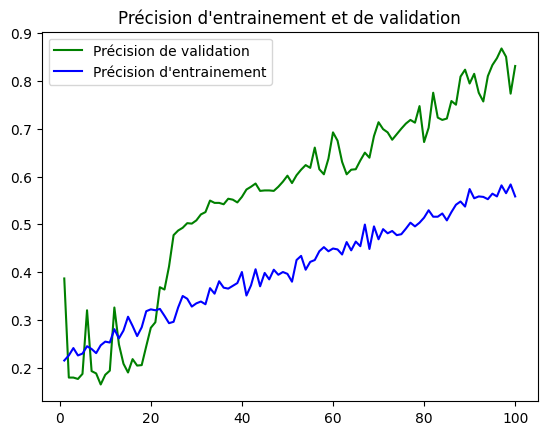

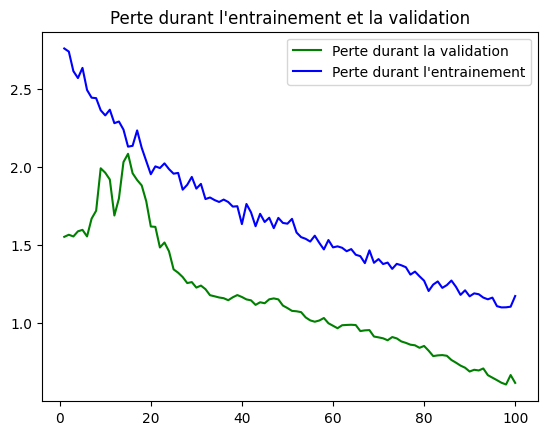

In [34]:
def training_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, val_acc, 'g', label="Précision de validation")
    plt.plot(epochs, acc, 'b', label="Précision d'entrainement")
    plt.title("Précision d'entrainement et de validation")
    plt.legend()
    plt.figure()
    plt.plot(epochs, val_loss, 'g', label="Perte durant la validation")
    plt.plot(epochs, loss, 'b', label="Perte durant l'entrainement")
    plt.title("Perte durant l'entrainement et la validation")
    plt.legend()
    plt.show()

training_plot(fit)

1/1 [==============================] - 0s 30ms/step
Matrice de confusion brute :
[[103   2   6  36  44]
 [  2  32   6   9  12]
 [  0   0 112  11   6]
 [  0   0   1 177   8]
 [  1   1   3  27 438]]




C:\Users\SebLa\AppData\Local\Temp\ipykernel_15776\369173688.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\SebLa\AppData\Local\Temp\ipykernel_15776\369173688.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


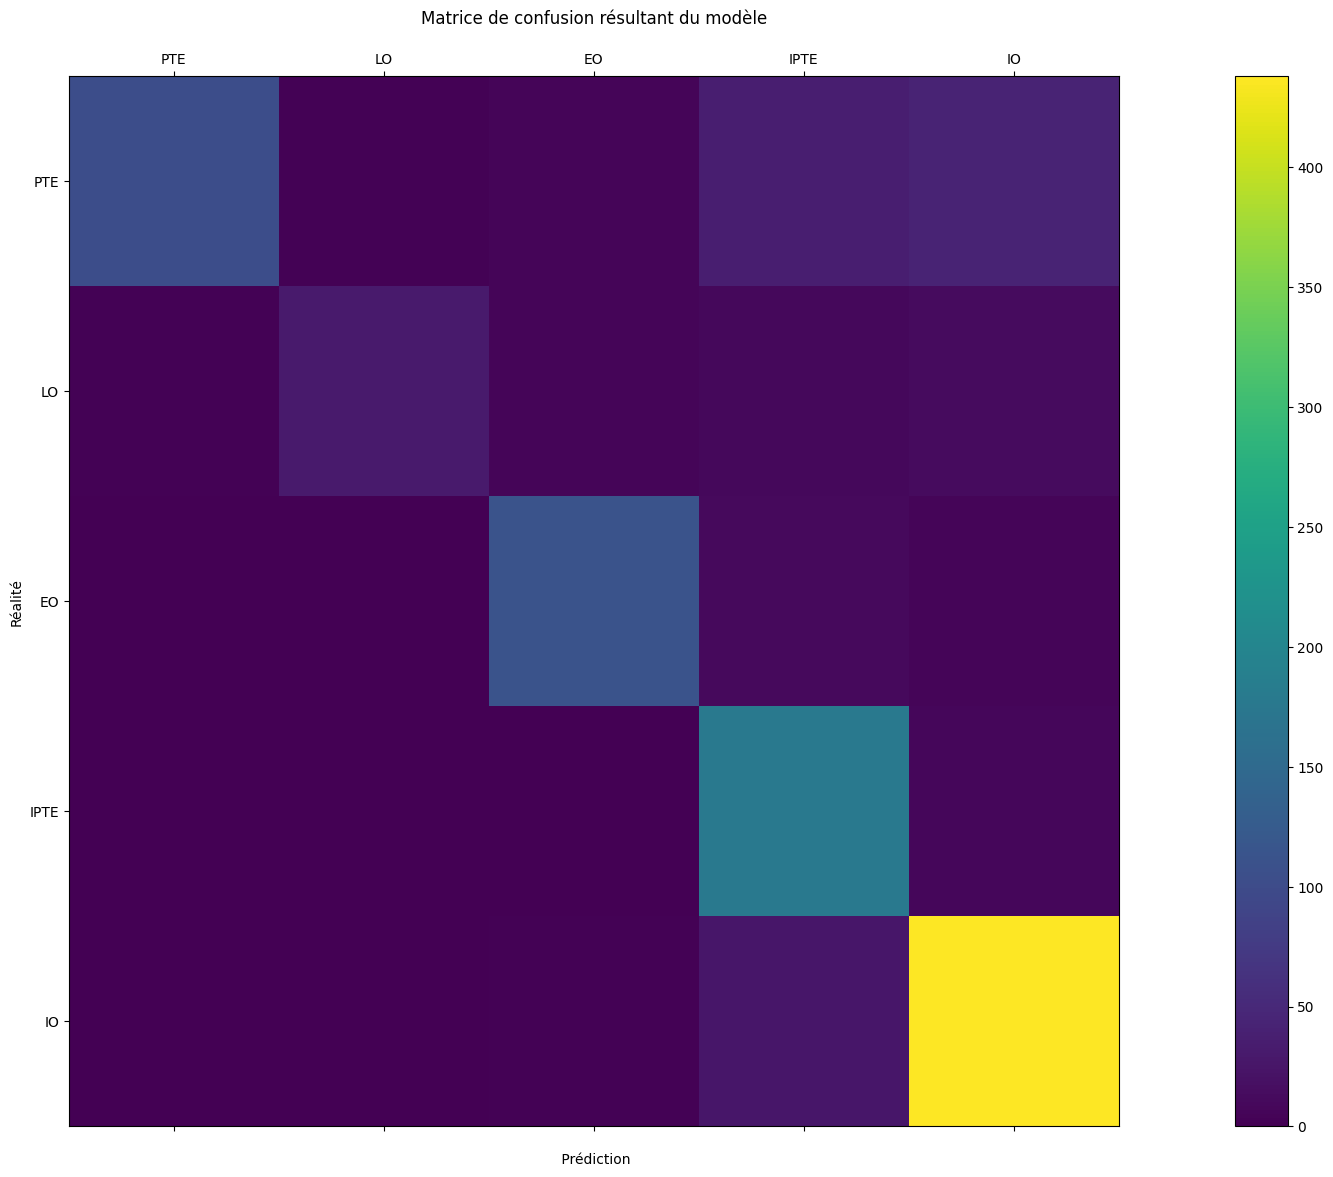

In [38]:
from sklearn.metrics import confusion_matrix
from numpy import argmax


# ------------- Calculs préliminaires -------------
y_true = []
y_pred = []
for x, y in val:
    y = tf.argmax(y, axis = 1)
    y_true.append(y)
    y_pred.append(tf.argmax(model.predict(x), axis = 1))

y_pred = tf.concat(y_pred, axis=0)
y_true = tf.concat(y_true, axis=0)


# ------------- Matrice de confusion -------------
cm = confusion_matrix(y_true, y_pred)

print("Matrice de confusion brute :")
print(cm)
print("\n")

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(211)
cax = ax.matshow(cm)
plt.title('Matrice de confusion')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('\n Prédiction')
plt.ylabel('Réalité')
plt.title("Matrice de confusion résultant du modèle\n")
plt.show()

In [39]:
from sklearn.metrics import classification_report

print("Rapport de classification :\n")
print(classification_report(y_true, y_pred, target_names=classes, digits=2))

Rapport de classification :

              precision    recall  f1-score   support

          EO       0.97      0.54      0.69       191
          IO       0.91      0.52      0.67        61
        IPTE       0.88      0.87      0.87       129
          LO       0.68      0.95      0.79       186
         PTE       0.86      0.93      0.90       470

    accuracy                           0.83      1037
   macro avg       0.86      0.76      0.78      1037
weighted avg       0.85      0.83      0.82      1037



# Transfer Learning